In [1]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from datetime import datetime
import random
from PIL import Image
import dask.dataframe as dd
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import time
import dask.array as da
import dask
import pandas as pd

In [2]:
file_list = "train.txt"#file cotaining all image paths
file = [line.rstrip().split(' ') for line in tuple(open(file_list, "r"))]#opening the file, and spliting with space

In [3]:
files, labels, year_months = list(zip(*file))#creating seperate list for files, labels, year_months

In [4]:
year_months

('2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12')

In [5]:
reference_date="2018-01-01"#initial data
reference_date = datetime(*map(int, reference_date.split("-")))#converting it into datetime 

In [6]:
#this function is to store all image path in the list 
all_days = list(range(len(files)))
for i in range(len(files)):
                planet, day = [], []
                date_count = 0
                for _, _, infiles in os.walk(files[i][1:]):
                    for infile in sorted(infiles):
                        if infile.startswith(year_months[i]):
                            planet.append(os.path.join(files[i], infile))#appending image path
                            day.append((datetime(int(str(infile.split('.')[0])[:4]), int(str(infile.split('.')[0][5:7])),
                                                  int(str(infile.split('.')[0])[8:])) -reference_date).days)#appending count from initial date
                            date_count += 1
                all_days[i] = list(zip(planet, day))#merging both the lists
                all_days[i].insert(0, date_count)

In [7]:
#this gives me all image paths present
#index is the month
month_index = 0#month_index ranging from [0,23] for 1st AOI, [24,47] for 2nd AOI and so on
#if 0 ->jan, 1->feb,....12->dec, 13->jan(next year)
day_index = 2#ranges from 0 to 30 or 31 depending on the month index chosen
#if the third index is set to 1 then we can easily find it's label
#if the third index is set to 0, then with the help of fourth index we can easily find the path 
all_days[month_index][day_index][0][:]

'/18N/24E-187N/2415_3082_13/PF-SR\\2018-01-02.tif'

In [8]:
#first 24 months ie 2years correspond to the same Area of Interest
cur_image_path = []
for month_index in range(0,24):
        for i in range(1, all_days[month_index][0]+1):
                cur_image_path.append(all_days[month_index][i][0][1:])

In [9]:
#All image path corresponding to one AOI

cur_image_path

['18N/24E-187N/2415_3082_13/PF-SR\\2018-01-01.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-02.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-03.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-04.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-05.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-06.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-07.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-08.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-09.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-10.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-11.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-12.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-13.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-14.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-15.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-16.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-17.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-18.tif',
 '18N/24E-187N/2415_3082_13/PF-SR\\2018-01-19.tif',
 '18N/24E-18

In [10]:
len(cur_image_path)

730

In [11]:

def normalized_difference( b1, b2):#calculates ndvi indices
    band1 = np.where((b1==0) & (b2==0), np.nan, b1) #for handling the case where denominator can be 0 for band1
    band2 = np.where((b1==0) & (b2==0), np.nan, b2)#for hanlding the case where denominator cab be 0 for band2
    return (band1 - band2) / (band1 + band2)

In [12]:
cur_image_path[0].split('/')[-1].split('\\')[-1] #curr images from the file

'2018-01-01.tif'

In [13]:
#calculating nvdi index for a given file, and creating .tif file for storing the nvdi index
folder1 = "ndvi-images/"
def find_ndvi_write_in_file(filename):
    with rasterio.open(filename) as src:
        # read the red and NIR bands
        band_red = src.read(3)#extracting red 
        band_nir = src.read(4)#extracting infrared
        ndvi = normalized_difference(band_nir, band_red)#calling ndvi function
        # write NDVI index to file
        output_filename1 = folder1+'ndvi_' + filename.split('/')[-1].split('\\')[-1]#creating output file path
        profile = src.profile.copy()
        profile.update(dtype=rasterio.float32, count=1, compress='lzw')
        with rasterio.open(output_filename1, 'w', **profile) as dst:
            dst.write(ndvi.astype(rasterio.float32), 1)#writing back in .tif format  


In [14]:
folder2 = "mndwi-images/"
def find_mndwi_write_in_file(filename):
    with rasterio.open(filename) as src:
        # read the red and NIR bands
        band_green = src.read(2)#extracting green
        band_nir = src.read(4)#extracting infrared
        mndwi = normalized_difference(band_green, band_nir)
        # write NDVI index to file
        output_filename2 = folder2+'mndwi_' + filename.split('/')[-1].split('\\')[-1]#creating output file path
        profile = src.profile.copy()
        profile.update(dtype=rasterio.float32, count=1, compress='lzw')
        with rasterio.open(output_filename2, 'w', **profile) as dst:
            dst.write(mndwi.astype(rasterio.float32), 1)#writing back in .tif format 


In [15]:
#calculating nvdi index for a given file, and appending it to ndvi list
ndvi_list = []
def find_ndvi_store_in_list(filename):
    with rasterio.open(filename) as src:
        # read the red and NIR bands
        band_red = src.read(3)#extracting red band
        band_nir = src.read(4)#extracting infrared band
        ndvi = normalized_difference(band_nir, band_red)#ndvi calculation for a given file 
        ndvi_list.append(ndvi) #appending ndvi index in the list 
        return ndvi

        

In [16]:
#calculating nvdi index for a given file, and appending it to ndvi list
mndwi_list = []
def find_mndwi_store_in_list(filename):
    with rasterio.open(filename) as src:
        # read the red and NIR bands
        band_green = src.read(2)#extracting green
        band_nir = src.read(4)#extracting infrared band
        mndwi = normalized_difference(band_green, band_nir)#mndwi calculation for a given file 
        mndwi_list.append(mndwi) #appending ndvi index in the list 
        return mndwi

Without dask, computation time for calculating ndvi index and appending in ndvi list

In [17]:
%%time
ndvi_list = []
#iterating over all files in the list and storing the ndvi index in the list
for filename in cur_image_path:
    find_ndvi_store_in_list(filename=filename)


CPU times: total: 29 s
Wall time: 46.2 s


Without dask, computation time for calculating mndwi index and appending in mndwi list

In [18]:
%%time
mndwi_list = []
#iterating over all files in the list and storing the mndwi index in the list
for filename in cur_image_path:
    find_mndwi_store_in_list(filename=filename)

CPU times: total: 38.2 s
Wall time: 39.8 s


In [30]:
image_list = []
mndwi_image_list = []
#We store one index from all 24 months, in a list for displaying them in a grid 
for i in range(10,len(ndvi_list),30):
    mndwi_image_list.append(mndwi_list[i])
    image_list.append(ndvi_list[i])    

In [31]:
len(image_list)

24

In [32]:
def plot_monthly_image(image_list,val):
    fig, axs = plt.subplots(4, 6)
    # Iterate through the rows and columns of the subplot grid
    for row in range(4):
        for col in range(6):
            # Calculate the index of the current image
            index = row * 6 + col
            if index < len(image_list):
                axs[row, col].imshow(image_list[index],cmap=val)
            # Remove the axis labels
            axs[row, col].axis('off')
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    # Display the grid of images
    plt.show()

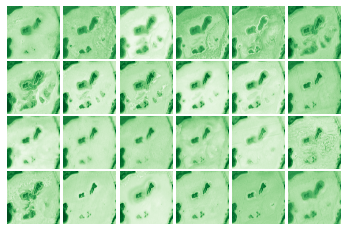

In [33]:
plot_monthly_image(image_list,"Greens")#ndvi indices for all 24 months

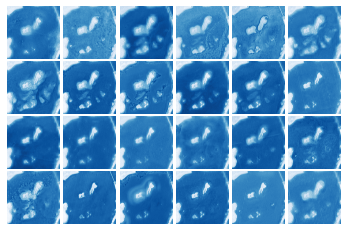

In [34]:
plot_monthly_image(mndwi_image_list,"Blues")#mndwi indices for all 24 months

In [35]:
#We store all indices from a month, in a list for displaying them in a grid 
image_month_list = []
mndwi_month_list = []
for i in range(0,30):
    image_month_list.append(ndvi_list[i])
    mndwi_month_list.append(mndwi_list[i])

In [36]:
len(image_month_list)

30

In [37]:
len(mndwi_month_list)

30

In [38]:
def plot_daily_images(image_month_list,val):
    fig, axs = plt.subplots(5, 6)
    for row in range(5):
        for col in range(6):
            # Calculate the index of the current image
            index = row * 6 + col
            if index < len(image_month_list):
                axs[row, col].imshow(image_month_list[index],cmap=val)
            # Remove the axis labels
            axs[row, col].axis('off')
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    # Display the grid of images
    plt.show()

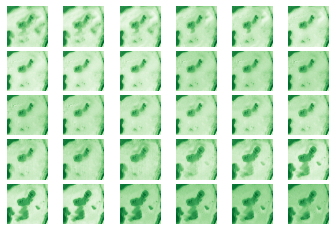

In [39]:
plot_daily_images(image_month_list,"Greens")#ndvi indices for 30 days starting from 2018-01-01

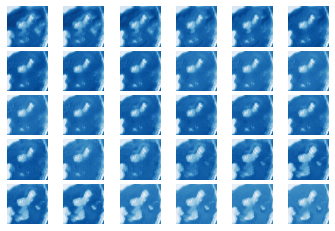

In [40]:
plot_daily_images(mndwi_month_list,"Blues")#mndwi indices for 30 days starting from 2018-01-01

Without dask, computation time for calculating ndvi index and writing it it back to .tif files 

In [41]:
%%time
#iterating over all files in the list and writing back the ndvi indices as .tif files
for filename in cur_image_path:
    find_ndvi_write_in_file(filename=filename)

CPU times: total: 1min 36s
Wall time: 2min 19s


Without dask, computation time for calculating mndwi index and writing it it back to .tif files 

In [42]:
%%time
#iterating over all files in the list and writing back the ndvi indices as .tif files
for filename in cur_image_path:
    find_mndwi_write_in_file(filename=filename)

CPU times: total: 1min 46s
Wall time: 2min 8s


In [43]:
ndvi_list[0].shape

(1024, 1024)

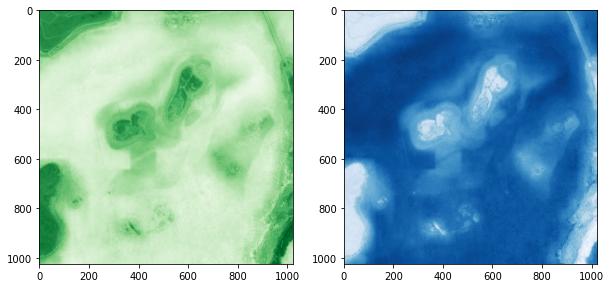

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ndvi_list[0], cmap='Greens')
ax[1].imshow(mndwi_list[0], cmap='Blues')

Initiating Dask Cluster (4 worker nodes created by default)

In [19]:
from dask.distributed import Client, LocalCluster#importing client and local cluster in our notebook
cluster = LocalCluster(n_workers=4)#defining local cluster with number of worker nodes
client = Client(cluster)#setting up cluster with out client(by default client creates 4 nodes) 

<!-- Creating list of dask objects in the list \
Dask.compute will parallely process the dask objects \ -->
With dask, computation time for calculating ndvi index and appending in ndvi list

In [19]:
%%time
final_list = []
delayed_results = [dask.delayed(find_ndvi_store_in_list)(filename) for filename in cur_image_path]#storing all dask delayed objects after applying the function in list 
final_list = dask.compute(*delayed_results)#parallel computing of all dask delayed objects by worker 
print()


CPU times: total: 54.2 s
Wall time: 35.2 s


In [20]:
final_list #this is list ndvi indices which we got after doing the computation using dask 

(array([[ 0.25484072,  0.26515387,  0.26577557, ..., -0.21649485,
         -0.21317158, -0.20422535],
        [ 0.25881986,  0.26738794,  0.2657602 , ..., -0.21635434,
         -0.21724138, -0.20422535],
        [ 0.26217228,  0.26503067,  0.26660545, ..., -0.22689076,
         -0.22735043, -0.21527778],
        ...,
        [ 0.0467706 ,  0.05228031,  0.0663667 , ..., -0.2979415 ,
         -0.26327194, -0.24278075],
        [ 0.03886926,  0.04817861,  0.06242638, ..., -0.29184549,
         -0.26834611, -0.23385301],
        [ 0.04166667,  0.04283966,  0.04761905, ..., -0.27094668,
         -0.26823793, -0.24770642]]),
 array([[ 0.255     ,  0.26492537,  0.26633479, ..., -0.20683761,
         -0.20415225, -0.19649123],
        [ 0.25960637,  0.26794554,  0.2657602 , ..., -0.20882852,
         -0.20618557, -0.19649123],
        [ 0.2627965 ,  0.26541884,  0.26760563, ..., -0.22147651,
         -0.221843  , -0.20970537],
        ...,
        [ 0.04761905,  0.05204873,  0.06516854, ..., -

In [21]:
for i in range(50):
    print(np.array_equiv(final_list[i],ndvi_list[i]))#comparing  "with dask list" with "wihtout dask list"

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


With dask, computation time for calculating mndwi index and appending in mndwi list

In [22]:
 
%%time
final_list=[]
delayed_results = [dask.delayed(find_mndwi_store_in_list)(filename) for filename in cur_image_path]#storing all dask delayed objects after applying the function in list 
final_list  = dask.compute(*delayed_results)#parallel computing of all dask delayed objects by worker nodes
print()


CPU times: total: 22.9 s
Wall time: 1min 4s


In [23]:
for i in range(50):
    print(np.array_equiv(final_list[i],mndwi_list[i]))#comparing  "with dask list" with "wihtout dask list for mndwi"

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
final_list

With dask, computation time for calculating ndvi index and writing it it back to .tif files

In [21]:

%%time
delayed_results = [dask.delayed(find_ndvi_write_in_file)(filename) for filename in cur_image_path]#storing all dask delayed objects after applying the function in list 
dask.compute(*delayed_results)#simultanously process the dask delayed objects
print()


CPU times: total: 1.31 s
Wall time: 32.8 s


With dask, computation time for calculating mndwi index and writing it it back to .tif files

In [22]:

%%time
delayed_results = [dask.delayed(find_mndwi_write_in_file)(filename) for filename in cur_image_path]#storing all dask delayed objects after applying the function in list 
dask.compute(*delayed_results)#simultanously process the dask delayed objects
print()


CPU times: total: 797 ms
Wall time: 28.7 s


In [ ]:
#Shutting down the cluster of worker nodes
client.shutdown()
